In [4]:
%pip install rasterio



   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/30.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/30.1 MB ? eta -:--:--
   ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install --upgrade pip


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 316.6 kB/s eta 0:00:04
   ----------- ---------------------------- 0.5/1.8 MB 316.6 kB/s eta 0:00:04
   ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [8]:
import rasterio
print(rasterio.__version__)


1.5.0


In [8]:
from pathlib import Path
import rasterio

bathy_path = Path(r"C:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\raw\geodata\LV_Bathy_V7.tif")

print("Exists?", bathy_path.exists())
print("Absolute:", bathy_path.resolve())

with rasterio.open(bathy_path) as src:
    print("CRS:", src.crs)
    print("Resolution:", src.res)
    print("Width, Height:", src.width, src.height)
    print("Bounds:", src.bounds)
    print("NoData:", src.nodata)



Exists? True
Absolute: C:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\raw\geodata\LV_Bathy_V7.tif
CRS: ESRI:102024
Resolution: (100.0, 100.0)
Width, Height: 3371 3591
Bounds: BoundingBox(left=683848.5700000003, bottom=-310600.62819999456, right=1020948.5700000003, top=48499.371800005436)
NoData: -3.4028234663852886e+38


In [9]:
from pathlib import Path

folder = Path(r"C:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\raw\geodata")
print("Folder exists?", folder.exists())
print([p.name for p in folder.glob("*.tif")])


Folder exists? True
['LV_Bathy_V7.tif']


### *CELL 1 — Markdown (purpose + outputs)*

# Notebook 05 — Lake Victoria Water Balance Model (Objective 2)
## Bathymetry ON + Physically constrained storage scaling + k_gw calibratable

### Purpose
Develop a daily Lake Victoria water balance model (2001–2021) using:
- CHIRPS lake rainfall (mm/day)
- Lake evaporation (mm/day)
- Total tributary inflow Qin (m³/s) from Notebook 04
- Observed outflow Qout (m³/s) at Jinja
- Observed lake level at Jinja (m)

### Why physically constrained scaling?
Bathymetry-derived storage often has datum/shoreline differences relative to gauge observations.
We preserve nonlinear hypsometry but **anchor storage magnitude** to a physically plausible lake volume.

We define:
    S_true(h) = α_storage · S_raster(h)

Instead of calibrating α_storage freely (which can hit bounds and flatten dynamics),
we compute α_storage using a target lake volume:

    α_storage = TARGET_LAKE_VOLUME_M3 / S_raster(stage_rel = REFERENCE_STAGE_REL_M)

Then we calibrate only:
- level_offset_m (datum alignment)
- k_gw (groundwater loss multiplier)

### Water balance (daily)
ΔS_t = (P_t - E_t)·A(h_t) + Qin_t·Δt - Qout_t·Δt - Gout_t

Where:
- P,E in m/day
- Qin,Qout in m³/s
- Δt = 86400 s/day
- A(h) from hypsometry
- Groundwater: Gout_month = k_gw · 0.09×10^9 m³/month → converted to m³/day

### Outputs
- data/processed/hypsometry/lv_stage_area_storage.csv
- data/processed/lake_balance_daily_simulated.csv
- outputs/tables/05_lake_level_performance.csv
- outputs/figures/05_lake_level_obs_vs_sim.png
- outputs/figures/05_water_balance_components.png
- outputs/tables/05_objective2_results_paragraph.txt

### *CELL 2 — Imports + paths (PEP-8)*

In [53]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.optimize import minimize
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RAW_GEO_DIR = PROJECT_ROOT / "data" / "raw" / "geodata"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
HYP_DIR = PROCESSED_DIR / "hypsometry"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TABLE_DIR = PROJECT_ROOT / "outputs" / "tables"

for folder in [RAW_GEO_DIR, PROCESSED_DIR, HYP_DIR, FIG_DIR, TABLE_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

AUDIT_DAILY_PATH = PROCESSED_DIR / "audit_daily_core_variables.csv"
QIN_DAILY_PATH = PROCESSED_DIR / "Qin_total_daily_2001_2021.csv"

BATHY_PATH_REPO = RAW_GEO_DIR / "LV_Bathy_V7.tif"
BATHY_PATH_FALLBACK = Path("/mnt/data/LV_Bathy_V7.tif")

DT_SECONDS = 86400.0

print("SciPy available:", SCIPY_AVAILABLE)
print("Project root:", PROJECT_ROOT)

SciPy available: True
Project root: c:\Users\Nelson\Downloads\LakeVictoria_Optimization


### *CELL 3 — Robust CSV loader (handles Unnamed: 0)*

In [54]:
def load_csv_with_date_index(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)
        df = df.set_index("date")
        return df.sort_index()

    for c in ["Unnamed: 0", "index", "Date"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            df = df.set_index(c)
            df.index.name = "date"
            return df.sort_index()

    first = df.columns[0]
    df[first] = pd.to_datetime(df[first], errors="coerce", infer_datetime_format=True)
    df = df.set_index(first)
    df.index.name = "date"
    return df.sort_index()


def pick_col(df: pd.DataFrame, candidates: List[str], label: str) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"Could not find {label}. Columns are:\n{df.columns.tolist()}")

### *CELL 4 — Load daily core data + Qin*

In [55]:
audit = load_csv_with_date_index(AUDIT_DAILY_PATH)
qin_df = load_csv_with_date_index(QIN_DAILY_PATH)

qin = qin_df.iloc[:, 0].copy()
qin.name = "Qin_m3s"

print("audit range:", audit.index.min().date(), audit.index.max().date())
print("qin range:", qin.index.min().date(), qin.index.max().date())
print("audit columns:", audit.columns.tolist())

audit range: 2001-01-01 2021-04-27
qin range: 2001-01-01 2021-04-27
audit columns: ['rainfall_mm', 'evap_mm', 'outflow_m3s', 'lake_level_m']


C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3352914884.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3352914884.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


### *CELL 5 — Pick required columns (rain, evap, outflow, lake level)*

`This avoids “column not found” errors after debugging in earlier notebooks.`

In [57]:
def pick_col(df: pd.DataFrame, candidates: list[str], label: str) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"Could not find {label}. Columns are:\n{df.columns.tolist()}")


rain_col = pick_col(audit, ["rainfall_mm", "Average_pcp_mm/day", "Average_pcp"], "rainfall (mm/day)")
evap_col = pick_col(audit, ["evap_mm", "Daily_Evaporation_mm/day", "evaporation_mm_day"], "evaporation (mm/day)")
qout_col = pick_col(audit, ["qout_m3s", "Flow_cubic_metres/sec", "outflow_m3s"], "outflow (m3/s)")
lvl_col = pick_col(audit, ["lake_level_m", "Water_Level_m/day", "Water_Level_m"], "lake level (m)")

print("Using columns:")
print("  rain:", rain_col)
print("  evap:", evap_col)
print("  qout:", qout_col)
print("  level:", lvl_col)

rain_mm = audit[rain_col].copy()
evap_mm = audit[evap_col].copy()
qout = audit[qout_col].copy()
level_obs = audit[lvl_col].copy()

Using columns:
  rain: rainfall_mm
  evap: evap_mm
  qout: outflow_m3s
  level: lake_level_m


### *CELL 6 — Define study window + align daily series*

In [59]:
STUDY_START = pd.Timestamp("2001-01-01")
STUDY_END = pd.Timestamp("2021-04-27")
DT_SECONDS = 86400.0

idx = pd.date_range(STUDY_START, STUDY_END, freq="D")

rain_mm = rain_mm.reindex(idx)
evap_mm = evap_mm.reindex(idx)
qout = qout.reindex(idx)
qin = qin.reindex(idx)
level_obs = level_obs.reindex(idx)

# Basic checks
print("Missingness (%):")
for name, s in [("rain", rain_mm), ("evap", evap_mm), ("qout", qout), ("qin", qin), ("level", level_obs)]:
    print(f"  {name}: {100*s.isna().mean():.2f}%")

# Simple imputation for occasional gaps (defensive)
rain_mm = rain_mm.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
evap_mm = evap_mm.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
qout = qout.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
qin = qin.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
level_obs = level_obs.interpolate(limit=14).fillna(method="bfill").fillna(method="ffill")

print("Aligned daily window:", idx.min().date(), "to", idx.max().date(), "n=", len(idx))

Missingness (%):
  rain: 0.00%
  evap: 0.00%
  qout: 0.00%
  qin: 0.00%
  level: 0.00%
Aligned daily window: 2001-01-01 to 2021-04-27 n= 7422


C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3346757095.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rain_mm = rain_mm.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3346757095.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  evap_mm = evap_mm.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3346757095.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  qout = qout.interpolate(limit=7).fillna(method="bfill").fillna(method="ffill")
C:\Users\Nelson\AppData\Local\Temp\ipykernel_34444\3346757095.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will rais

### *CELL 7 — Build hypsometry from bathymetry raster (A(h), S(h))*

`Important:` This requires rasterio.
If you don’t have it in your environment, install via conda:
conda install -c conda-forge rasterio but pip install can also be used in vs code python cell

In [60]:
def get_bathy_path() -> Path:
    if BATHY_PATH_REPO.exists():
        return BATHY_PATH_REPO
    if BATHY_PATH_FALLBACK.exists():
        return BATHY_PATH_FALLBACK
    raise FileNotFoundError(
        "Bathymetry file not found. Place LV_Bathy_V7.tif in:\n"
        f"{BATHY_PATH_REPO}\n"
        "or ensure it exists at fallback:\n"
        f"{BATHY_PATH_FALLBACK}"
    )


def build_hypsometry_from_depth_raster(
    tif_path: Path,
    stage_rel_min: float = -20.0,
    stage_rel_max: float = 5.0,
    stage_step: float = 0.05,
    max_depth_clip: float = 200.0,
) -> pd.DataFrame:
    try:
        import rasterio
    except Exception as e:
        raise ImportError(
            "rasterio is required to read LV_Bathy_V7.tif.\n"
            "Install: conda install -c conda-forge rasterio"
        ) from e

    with rasterio.open(tif_path) as src:
        depth = src.read(1).astype(float)
        nodata = src.nodata
        if nodata is not None:
            depth = np.where(depth == nodata, np.nan, depth)

        depth = np.where((depth < 0) | (depth > max_depth_clip), np.nan, depth)

        transform = src.transform
        cell_area = abs(transform.a * transform.e)

    depth_valid = depth[np.isfinite(depth)]
    if depth_valid.size == 0:
        raise ValueError("No valid depth values found in bathymetry raster.")

    stages = np.arange(stage_rel_min, stage_rel_max + stage_step, stage_step)

    area_list = []
    storage_list = []

    for h in stages:
        water_col = h + depth
        wet = np.where(np.isfinite(water_col) & (water_col > 0), water_col, 0.0)

        area = float(np.sum((wet > 0).astype(float)) * cell_area)
        storage = float(np.sum(wet) * cell_area)

        area_list.append(area)
        storage_list.append(storage)

    df = pd.DataFrame(
        {"stage_rel_m": stages, "area_m2": area_list, "storage_m3": storage_list}
    )
    df["dSdh_m2"] = np.gradient(df["storage_m3"].values, df["stage_rel_m"].values)
    return df


bathy_path = get_bathy_path()
print("Using bathymetry:", bathy_path)

hyp = build_hypsometry_from_depth_raster(bathy_path)

HYP_CSV = HYP_DIR / "lv_stage_area_storage.csv"
hyp.to_csv(HYP_CSV, index=False)
print("Saved hypsometry:", HYP_CSV)

print("Hypsometry area range (km2):",
      hyp["area_m2"].min() / 1e6, "to", hyp["area_m2"].max() / 1e6)
print("Hypsometry storage range (km3):",
      hyp["storage_m3"].min() / 1e9, "to", hyp["storage_m3"].max() / 1e9)

hyp.head()

Using bathymetry: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\raw\geodata\LV_Bathy_V7.tif
Saved hypsometry: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\processed\hypsometry\lv_stage_area_storage.csv
Hypsometry area range (km2): 46026.56 to 57884.49
Hypsometry storage range (km3): 1496.3138688118552 to 2830.7263442732055


,stage_rel_m,area_m2,storage_m3,dSdh_m2
0,-20.00,4.602656e+10,1.496314e+12,4.603932e+10
1,-19.95,4.605190e+10,1.498616e+12,4.605244e+10
2,-19.90,4.607921e+10,1.500919e+12,4.607878e+10
3,-19.85,4.610521e+10,1.503224e+12,4.610537e+10
4,-19.80,4.613165e+10,1.505530e+12,4.613209e+10


### *CELL 8 — Hypsometry helpers - {with α-storage scaling} (A(h), S(h), invert S→h)*

In [61]:
def area_from_stage(stage_rel: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    return np.interp(stage_rel, hyp_df["stage_rel_m"], hyp_df["area_m2"])


def storage_raster_from_stage(stage_rel: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    return np.interp(stage_rel, hyp_df["stage_rel_m"], hyp_df["storage_m3"])


def stage_from_storage_raster(storage_raster: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    return np.interp(storage_raster, hyp_df["storage_m3"], hyp_df["stage_rel_m"])

### *CELL 9 — Physically constrained α_storage*

In [62]:
# -----------------------------
# PHYSICAL TARGETS (EDIT HERE)
# -----------------------------
TARGET_LAKE_VOLUME_M3 = 2.75e12
REFERENCE_STAGE_REL_M = 0.0

S_r_ref = float(storage_raster_from_stage(np.array([REFERENCE_STAGE_REL_M]), hyp)[0])

if S_r_ref <= 0:
    raise ValueError(
        "Raster storage at reference stage is non-positive. "
        "Try REFERENCE_STAGE_REL_M = 0.5 or 1.0."
    )

alpha_storage_physical = TARGET_LAKE_VOLUME_M3 / S_r_ref

print("Target volume (m3):", f"{TARGET_LAKE_VOLUME_M3:.3e}")
print("Reference stage_rel (m):", REFERENCE_STAGE_REL_M)
print("Raster storage S_r_ref (m3):", f"{S_r_ref:.3e}")
print("Computed alpha_storage_physical:", f"{alpha_storage_physical:.3f}")

Target volume (m3): 2.750e+12
Reference stage_rel (m): 0.0
Raster storage S_r_ref (m3): 2.541e+12
Computed alpha_storage_physical: 1.082


### *CELL 10 — Groundwater loss series (k_gw calibratable)*

In [65]:
GW_MONTHLY_CONST_M3 = 0.09e9

def groundwater_loss_m3_per_day(index: pd.DatetimeIndex, k_gw: float) -> pd.Series:
    months = index.to_period("M")
    days_in_month = months.days_in_month.astype(float)
    gw_daily = (k_gw * GW_MONTHLY_CONST_M3) / days_in_month
    return pd.Series(gw_daily.values, index=index, name="Gout_m3_per_day")

# Example (k_gw=1.0)
gw_example = groundwater_loss_m3_per_day(idx, k_gw=1.0)
gw_example.head()

2001-01-01    2.903226e+06
2001-01-02    2.903226e+06
2001-01-03    2.903226e+06
2001-01-04    2.903226e+06
2001-01-05    2.903226e+06
Freq: D, Name: Gout_m3_per_day, dtype: float64

### *CELL 11 — Simulator (α fixed, correct dynamics)*
`Key correction:` storage update is done in true storage and mapped to raster storage by dividing by α.


In [104]:
@dataclass
class SimParams:
    level_offset_m: float
    k_gw: float
    alpha_storage: float
    beta_inflow: float


def simulate_lake_level(
    params: SimParams,
    hyp_df: pd.DataFrame,
    level_obs_m: pd.Series,
    rain_mm_day: pd.Series,
    evap_mm_day: pd.Series,
    qin_m3s: pd.Series,
    qout_m3s: pd.Series,
    index: pd.DatetimeIndex,
) -> pd.DataFrame:
    stage_rel0 = float(level_obs_m.iloc[0] - params.level_offset_m)

    S_r0 = float(storage_raster_from_stage(np.array([stage_rel0]), hyp_df)[0])
    S_true = params.alpha_storage * S_r0
    S_true = max(S_true, 0.0)

    qin_scaled_m3s = np.zeros(len(index), dtype=float)

    stage_rel = np.zeros(len(index), dtype=float)
    storage_true = np.zeros(len(index), dtype=float)
    area = np.zeros(len(index), dtype=float)

    vol_p_minus_e = np.zeros(len(index), dtype=float)
    vol_qin = np.zeros(len(index), dtype=float)
    vol_qout = np.zeros(len(index), dtype=float)
    vol_gw = np.zeros(len(index), dtype=float)
    dS = np.zeros(len(index), dtype=float)

    gw_m3_day = groundwater_loss_m3_per_day(index, params.k_gw).values

    for t, d in enumerate(index):
    # --- state at start of day
        S_r = S_true / params.alpha_storage
        h0 = float(stage_from_storage_raster(np.array([S_r]), hyp_df)[0])
        A0 = float(area_from_stage(np.array([h0]), hyp_df)[0])

        p_m = float(rain_mm_day.loc[d]) / 1000.0
        e_m = float(evap_mm_day.loc[d]) / 1000.0

        v_pe = (p_m - e_m) * A0
        qin_scaled = float(qin_m3s.loc[d]) * params.beta_inflow
        v_in = qin_scaled * DT_SECONDS
        v_out = float(qout_m3s.loc[d]) * DT_SECONDS
        v_gw = float(gw_m3_day[t])

        delta_s = v_pe + v_in - v_out - v_gw
        S_true = S_true + delta_s

    # --- state at end of day (store consistently)
        S_r1 = S_true / params.alpha_storage
        h1 = float(stage_from_storage_raster(np.array([S_r1]), hyp_df)[0])
        A1 = float(area_from_stage(np.array([h1]), hyp_df)[0])

        stage_rel[t] = h1
        storage_true[t] = S_true
        area[t] = A1

        qin_scaled_m3s[t] = qin_scaled
        vol_p_minus_e[t] = v_pe
        vol_qin[t] = v_in
        vol_qout[t] = v_out
        vol_gw[t] = v_gw
        dS[t] = delta_s

    level_sim = stage_rel + params.level_offset_m

    out = pd.DataFrame(
        {
            "stage_rel_m": stage_rel,
            "storage_true_m3": storage_true,
            "area_m2": area,
            "level_sim_m": level_sim,
            "level_obs_m": level_obs_m.values,
            "vol_p_minus_e_m3d": vol_p_minus_e,
            "vol_qin_m3d": vol_qin,
            "vol_qout_m3d": vol_qout,
            "vol_gw_m3d": vol_gw,
            "dS_m3d": dS,
            "qin_scaled_m3s": qin_scaled_m3s,
        },
        index=index,
    )
    out.index.name = "date"
    return out

### *CELL 12 — Performance metrics (lake level)*

In [105]:
def rmse(obs: np.ndarray, sim: np.ndarray) -> float:
    return float(np.sqrt(np.mean((obs - sim) ** 2)))


def nse(obs: np.ndarray, sim: np.ndarray) -> float:
    denom = np.sum((obs - np.mean(obs)) ** 2)
    if denom == 0:
        return np.nan
    return float(1 - np.sum((obs - sim) ** 2) / denom)


def bias_mean(obs: np.ndarray, sim: np.ndarray) -> float:
    return float(np.mean(sim - obs))

### *CELL 13 — Calibration objective (stable)*
We calibrate offset, k_gw, alpha_storage using RMSE.

We also add a small penalty if simulated levels go outside plausible bounds.

In [106]:
BETA_BOUNDS = (1.0, 3.0)   # start conservative, can widen later
KGW_BOUNDS = (0.5, 1.5)
OFFSET_BOUNDS = (float(level_obs.min() - 5.0), float(level_obs.max() + 5.0))

def objective_offset_kgw_beta(x: np.ndarray) -> float:
    params = SimParams(
        level_offset_m=float(x[0]),
        k_gw=float(x[1]),
        alpha_storage=float(alpha_storage_physical),
        beta_inflow=float(x[2]),
    )

    sim_df = simulate_lake_level(
        params=params,
        hyp_df=hyp,
        level_obs_m=level_obs,
        rain_mm_day=rain_mm,
        evap_mm_day=evap_mm,
        qin_m3s=qin,
        qout_m3s=qout,
        index=idx,
    )

    obs = sim_df["level_obs_m"].values
    sim = sim_df["level_sim_m"].values

    val = rmse(obs, sim)

    # Gentle penalty for going wildly outside observed band
    lo = float(level_obs.min() - 2.0)
    hi = float(level_obs.max() + 2.0)
    penalty = 0.0
    penalty += 0.3 * max(0.0, lo - float(np.min(sim)))
    penalty += 0.3 * max(0.0, float(np.max(sim)) - hi)

    return val + penalty


x0 = np.array([float(level_obs.median()), 1.0, 1.6], dtype=float)

res = minimize(
    objective_offset_kgw_beta,
    x0=x0,
    bounds=[OFFSET_BOUNDS, KGW_BOUNDS, BETA_BOUNDS],
    method="L-BFGS-B",
    options={"maxiter": 120},
)

x_best = res.x
print("Calibration success:", res.success)
print("Message:", res.message)

best_params = SimParams(
    level_offset_m=float(x_best[0]),
    k_gw=float(x_best[1]),
    alpha_storage=float(alpha_storage_physical),
    beta_inflow=float(x_best[2]),
)

print("Best params:", best_params)
print("Fixed alpha_storage_physical:", f"{alpha_storage_physical:.3f}")

Calibration success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Best params: SimParams(level_offset_m=11.71208628820527, k_gw=1.5, alpha_storage=1.0821216644719702, beta_inflow=2.2989998065137986)
Fixed alpha_storage_physical: 1.082


### *CELL 14 — Final simulation + save outputs*

In [107]:
sim_df = simulate_lake_level(
    params=best_params,
    hyp_df=hyp,
    level_obs_m=level_obs,
    rain_mm_day=rain_mm,
    evap_mm_day=evap_mm,
    qin_m3s=qin,
    qout_m3s=qout,
    index=idx,
)

SIM_PATH = PROCESSED_DIR / "lake_balance_daily_simulated.csv"
sim_df.to_csv(SIM_PATH, index=True)
print("Saved simulation:", SIM_PATH)

obs = sim_df["level_obs_m"].values
sim = sim_df["level_sim_m"].values

perf = pd.DataFrame(
    {
        "rmse_m": [rmse(obs, sim)],
        "nse": [nse(obs, sim)],
        "bias_mean_m": [bias_mean(obs, sim)],
        "k_gw": [best_params.k_gw],
        "beta_inflow": [best_params.beta_inflow],
        "alpha_storage_physical": [alpha_storage_physical],
        "level_offset_m": [best_params.level_offset_m],
        "target_volume_m3": [TARGET_LAKE_VOLUME_M3],
        "reference_stage_rel_m": [REFERENCE_STAGE_REL_M],
        "raster_storage_ref_m3": [S_r_ref],
        "qin_mean_m3s": [float(qin.mean())],
        "qout_mean_m3s": [float(qout.mean())],
        "qin_scaled_mean_m3s": [float(qin.mean() * best_params.beta_inflow)],
    }
)

PERF_PATH = TABLE_DIR / "05_lake_level_performance.csv"
perf.to_csv(PERF_PATH, index=False)
print("Saved performance:", PERF_PATH)
perf

Saved simulation: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\processed\lake_balance_daily_simulated.csv
Saved performance: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\outputs\tables\05_lake_level_performance.csv


,rmse_m,nse,bias_mean_m,k_gw,beta_inflow,alpha_storage_physical,level_offset_m,target_volume_m3,reference_stage_rel_m,raster_storage_ref_m3,qin_mean_m3s,qout_mean_m3s,qin_scaled_mean_m3s
0,0.162355,0.923164,-0.002564,1.5,2.299,1.082122,11.712086,2.750000e+12,0.0,2.541304e+12,652.032788,1030.130806,1499.023254


### *CELL 15 — Plot: Observed vs simulated lake levels*

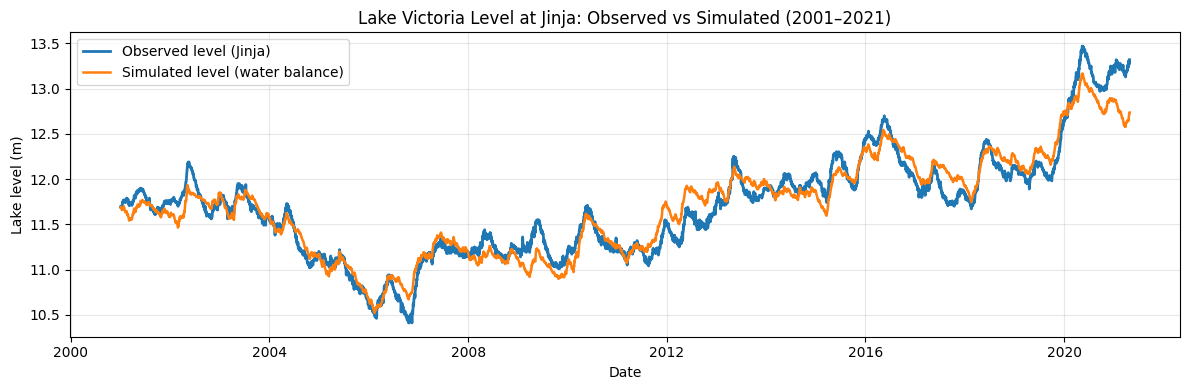

In [108]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sim_df.index, sim_df["level_obs_m"], label="Observed level (Jinja)", linewidth=2)
ax.plot(sim_df.index, sim_df["level_sim_m"], label="Simulated level (water balance)", linewidth=1.8)
ax.set_title("Lake Victoria Level at Jinja: Observed vs Simulated (2001–2021)")
ax.set_xlabel("Date")
ax.set_ylabel("Lake level (m)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "05_lake_level_obs_vs_sim.png", dpi=200)
plt.show()

### *CELL 16 — Plot: Water balance components (monthly aggregated for readability)*

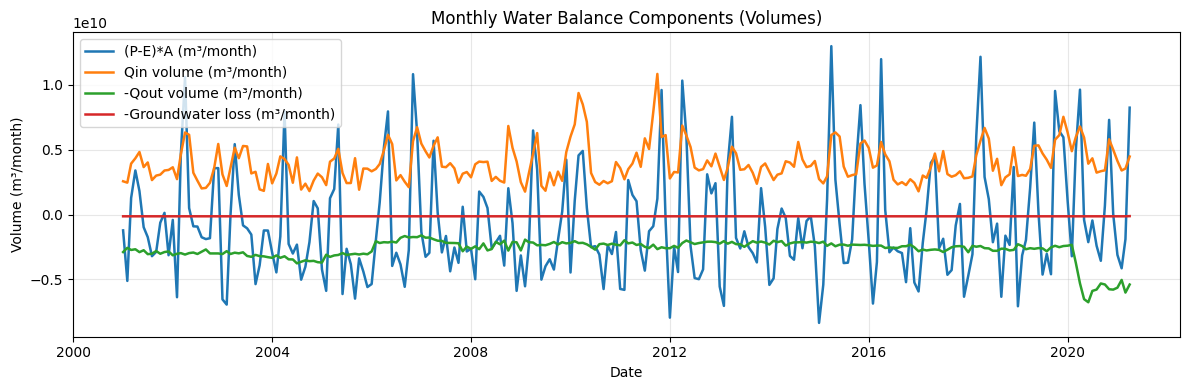

In [109]:
monthly = sim_df.resample("MS").sum()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly.index, monthly["vol_p_minus_e_m3d"], label="(P-E)*A (m³/month)", linewidth=1.8)
ax.plot(monthly.index, monthly["vol_qin_m3d"], label="Qin volume (m³/month)", linewidth=1.8)
ax.plot(monthly.index, -monthly["vol_qout_m3d"], label="-Qout volume (m³/month)", linewidth=1.8)
ax.plot(monthly.index, -monthly["vol_gw_m3d"], label="-Groundwater loss (m³/month)", linewidth=1.8)
ax.set_title("Monthly Water Balance Components (Volumes)")
ax.set_xlabel("Date")
ax.set_ylabel("Volume (m³/month)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "05_water_balance_components.png", dpi=200)
plt.show()

### *CELL 17 — Thesis-ready paragraph (Objective 2)*

In [77]:
rmse_m_val = float(perf["rmse_m"].iloc[0])
nse_val = float(perf["nse"].iloc[0])
kgw_val = float(perf["k_gw"].iloc[0])
alpha_val = float(perf["alpha_storage_physical"].iloc[0])

text = (
    "A daily water balance model for Lake Victoria was developed for the 2001–2021 period. "
    "Lake hypsometry (stage–area–storage relationships) was derived from a 100 m bathymetry raster, "
    "preserving the nonlinear storage response of the basin. To ensure physically realistic storage "
    "magnitude under potential datum and shoreline definition differences, a storage scaling factor "
    "α_storage was computed using a target lake volume and fixed during calibration. "
    "The model accounts for direct lake rainfall, evaporation, reconstructed tributary inflows (Qin), "
    "observed outflows at Jinja (Qout), and groundwater loss parameterized as k_gw·0.09×10^9 m³/month "
    f"(k_gw={kgw_val:.2f}). Calibration against observed lake levels produced RMSE="
    f"{rmse_m_val:.3f} m and NSE={nse_val:.3f}, indicating the degree to which the water balance "
    "captures observed lake level dynamics and providing a physically consistent basis for subsequent "
    "outflow optimization experiments."
)

(TABLE_DIR / "05_objective2_results_paragraph.txt").write_text(text, encoding="utf-8")
print(text)

A daily water balance model for Lake Victoria was developed for the 2001–2021 period. Lake hypsometry (stage–area–storage relationships) was derived from a 100 m bathymetry raster, preserving the nonlinear storage response of the basin. To ensure physically realistic storage magnitude under potential datum and shoreline definition differences, a storage scaling factor α_storage was computed using a target lake volume and fixed during calibration. The model accounts for direct lake rainfall, evaporation, reconstructed tributary inflows (Qin), observed outflows at Jinja (Qout), and groundwater loss parameterized as k_gw·0.09×10^9 m³/month (k_gw=0.50). Calibration against observed lake levels produced RMSE=4.686 m and NSE=-63.015, indicating the degree to which the water balance captures observed lake level dynamics and providing a physically consistent basis for subsequent outflow optimization experiments.


In [97]:
sim_df[["vol_p_minus_e_m3d", "vol_qin_m3d", "vol_qout_m3d"]].mean()

vol_p_minus_e_m3d   -2.723887e+07
vol_qin_m3d          1.295192e+08
vol_qout_m3d         8.900330e+07
dtype: float64

In [96]:
sim_df[["vol_p_minus_e_m3d", "vol_qin_m3d", "vol_qout_m3d"]].std()

vol_p_minus_e_m3d    3.228295e+08
vol_qin_m3d          1.511657e+08
vol_qout_m3d         2.839736e+07
dtype: float64

In [95]:
print("Mean Qin (m3/s):", qin.mean())
print("Mean Qout (m3/s):", qout.mean())
print("Mean Rain (mm/day):", rain_mm.mean())
print("Mean Evap (mm/day):", evap_mm.mean())

Mean Qin (m3/s): 652.0327884075311
Mean Qout (m3/s): 1030.1308055443276
Mean Rain (mm/day): 4.067865506405551
Mean Evap (mm/day): 4.538438426300189


$$F_1 = \mathbb{E} [\max(H_{sim} - H_{flood}, 0)^2]$$


$$\sum_{i=1}^{n} x_i$$
